In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import FinanceDataReader as fdr

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from datetime import datetime
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from hyperopt import fmin, tpe, space_eval, Trials, hp, rand, anneal

import xgboost as xgb
from xgboost import plot_importance

import pickle

### 데이터 생성

- **add_features( )** : 주가데이터가 담긴 데이터프레임에 원하는 window 크기의 feature를 생성하는 함수
- **labeling( )** : n일 이동평균 대비 m일 후 m일 이동평균 상승 여부에 따라 라벨링
- **feature_scaling( )** : 주어진 feature에 대해 스케일링을 진행
- **make_data( )** : 데이터 생성

- `MA_5` : 5일 이동평균  
- `STD` : n일 종가의 표준편차
- `Upper`, `Lower` : MA_5에서 2 * STD의 값을 더하고 빼준 구간
- `Out` : 당일 종가가 Upper, Lower 벗어난 경우 각각 1, -1
- `MA` : n일 이동평균
- `OBV` : 거래량의 누적치, 주가가 오르면 더해주고, 내리면 빼줌
- `CCI` : 주가와 이동평균 차이를 측정하여 구한 모멘텀 지표
- `fast_k` (스토캐스틱) : n일 동안의 최저, 최고가 범위에서 현재 종가의 위치
- `fask_d` : fask_k의 n일 이동평균
- `ROC` : n일 전 종가 대비 현재 종가 변화율
- `RSI` (상대강도지수) : n일 동안의 종가 상승 / 하락 평균을 이용한 모멘텀 지표
- `MFI` : 가격과 거래량을 모두 반영한 모멘텀 지표
- `ks_fast` : 코스피 데이터에 반영한 fask_k
- `ks_ROC` : 코스피 데이터에 반영한 ROC
- `DP` : n일 종가 이동평균 대비 당일종가 (-1~1 범위 갖도록 값에 1 빼서 사용) (=이격도-1)
- `RSI_DP` : RSI의 n일 이동평균 대비 현재 RSI
- `ks_DP` : 코스피 지수의 DP

In [2]:
# stock_data = pd.read_csv('./Stock_price/stock_data.csv')
# 코스피 데이터 생성
ks11 = fdr.DataReader('KS11', '2012-06-01')
ks11['ks_fast'] = ((ks11['Close'] - ks11['Low'].rolling(14).min()) / (ks11['High'].rolling(14).max() - ks11['Low'].rolling(14).min())) * 100

In [30]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

def adf_kpss_test_for_cols(df, columns):
    # print('분석 대상 :', df['Code'].values[0])
    for col in columns:
        # print("--------------------{0:^10}---------------------".format(col))
        adfuller_test = adfuller(df[col], autolag= "AIC")
        if adfuller_test[1] > 0.05:
            print(df['company_name'].values[0], col, adfuller_test[1])
        # print("ADF test statistic: {}".format(adfuller_test[0]))
        # print("p-value: {}".format(adfuller_test[1]))
        # kpsstest = kpss(df[col], regression="c", nlags="auto")
        # print("KPSS test statistic: {}".format(kpsstest[0]))
        # print("p-value: {}".format(kpsstest[1]))

In [4]:
# 5일 이동평균
def add_ma_5(df):
    df['MA_5'] = df['Close'].rolling(window=5).mean().values
    return

# 볼린저 밴드
def add_bollinger_bands(df, window=20, std=2):
    # 표준편차 계산
    df['STD'] = df['Close'].rolling(window=window).std()
    # 상단 볼린저 밴드 계산
    df['Upper'] = df['MA_5'] + (std * df['STD'])
    # 하단 볼린저 밴드 계산
    df['Lower'] = df['MA_5'] - (std * df['STD'])
    return

def add_Out(df):
    df['Out'] = ((df['Upper'] - df['Close'] < 0) + 0) + -((df['Lower'] > df['Close']) + 0)
    return

# 이동평균
def add_moving_avg(df, window=20):
    df['MA'] = df['Close'].rolling(window=window).mean().values
    return

# 거래량 관련
def add_obv(df):
    obv = [0]
    for i in range(1, len(df)):
        if df['Close'][i] > df['Close'][i-1]:
            obv.append(obv[-1] + df['Volume'][i])
        elif df['Close'][i] < df['Close'][i-1]:
            obv.append(obv[-1] - df['Volume'][i])
        else:
            obv.append(obv[-1])
    df['OBV'] = obv
    return

def add_cci(df, window=20):
    m = (df['High'] + df['Low'] + df['Close']) / 3
    n = m.rolling(window).mean()
    # d = (abs(m - n)).rolling(window).mean()
    d = m.rolling(window).apply(lambda x: pd.Series(x).sub(x.mean()).abs().mean())
    # d = m.rolling(window).apply(lambda x : pd.Series(x).mad())
    df['CCI'] = (m - n) / (0.015 * d)
    return

def add_stochastic_fast_k(df, window=14):
    df['fast_k'] = ((df['Close'] - df['Low'].rolling(window).min()) / (df['High'].rolling(window).max() - df['Low'].rolling(window).min())) * 100
    return

def add_stochastic_fast_d(df, window=9):
    df['fast_d'] = df['fast_k'].rolling(window=window).mean().values
    return

def add_ROC(df, window=1):
    df['ROC'] = df.Close.diff(window) / df.Close.shift(window)
    return

def add_RSI(df, period=14):
    delta = df["Close"].diff() # 종가의 차이를 계산
    up, down = delta.copy(), delta.copy() # 상승분과 하락분을 따로 계산하기 위해 복사
    up[up < 0] = 0 # 상승분, U
    down[down > 0] = 0 # 하락분, D
    _gain = up.ewm(com=(period - 1), min_periods=period).mean() # AU(U값의 평균)
    _loss = down.abs().ewm(com=(period - 1), min_periods=period).mean() # DU(D값의 평균)
    RS = _gain / _loss
    rsi = pd.Series(100 - (100 / (1 + RS)), name="RSI")
    df['RSI'] = rsi
    return

def add_RSI_DP(df, window=2):
    df['RSI_DP'] = np.round(df['RSI'] / df['RSI'].rolling(window=window).mean(), 4) - 1
    return

def add_DP(df, window=20):
    df['DP'] = np.round(df['Close'] / df['Close'].rolling(window=window).mean(), 4) - 1
    return

def add_MFI(df, period = 14): 
	# 우선적으로 각 기간에 맞게 평균 가격(TP)을 구합니다. 
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3  # TP
    money_flow = typical_price * df['Volume']
    positive_flow =[] 
    negative_flow = []
    
    # 반복문을 돌면서 기간별 양의 RMF, 음의 RMF를 구현합니다.
    # Loop through the typical price 
    for i in range(1, len(typical_price)):
        if typical_price[i] > typical_price[i-1]: 
            positive_flow.append(money_flow[i-1])
            negative_flow.append(0) 
        elif typical_price[i] < typical_price[i-1]:
            negative_flow.append(money_flow[i-1])
            positive_flow.append(0)
        else: 
            positive_flow.append(0)
            negative_flow.append(0)
    
    positive_mf = []
    negative_mf = [] 
    # 기간동안 평균 가격들의 분류가 끝난 경우, RMF 계산식을 이용해 평균 가격과 당일 거래량을 곱합니다. 
    # Get all of the positive money flows within the time period
    for i in range(period-1, len(positive_flow)):
        positive_mf.append(sum(positive_flow[i+1-period : i+1]))
    # Get all of the negative money flows within the time period  
    for i in range(period-1, len(negative_flow)):
        negative_mf.append(sum(negative_flow[i+1-period : i+1]))
    # for i in range(len(positive_mf)):
    #     if positive_mf[i] == 0 and negative_mf[i] == 0:
    #         negative_mf[i] = 1
    # MFR을 계산합니다. 그 후 MFI를 구합니다. 
    mfi = list(100 * (np.array(positive_mf) / (np.array(positive_mf)  + np.array(negative_mf))))
    mfi = list(np.repeat(np.nan,len(df)-len(mfi))) + mfi
    df['MFI'] = mfi
    return

# 종목 데이터에 코스피 데이터를 날짜 기준으로 병합
def add_ks_data(df, ks11, window=1):
    # df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    ks11['ks_ROC'] = np.round(ks11.Close.diff(window) / ks11.Close.shift(window), 4)
    ks11['ks_DP'] = np.round(ks11.Close / ks11.Close.rolling(window=window).mean().values, 4) - 1
    data = pd.merge(df, ks11[['ks_ROC', 'ks_DP', 'ks_fast']], left_on='Date', right_index=True)
    return data

def labeling(data, a_window=5, b_window=5):
    a_name = 'MA_'+str(a_window)
    b_name = 'MA_'+str(b_window)
    data[a_name] = data['Close'].rolling(window=a_window).mean().values
    data[b_name] = data['Close'].rolling(window=b_window).mean().values
    data['label'] = None
    for i in range(len(data)-b_window):
        data.loc[i, 'label'] = 1 if data.loc[i, a_name] <= data.loc[i+b_window, b_name] else 0
    return

def add_FROC(df):
    df['FROC_60'] = df.Close.shift(-60) / df.Close - 1
    df['FROC_30'] = df.Close.shift(-30) / df.Close - 1
    df['FROC_10'] = df.Close.shift(-10) / df.Close - 1
    df['FROC_5'] = df.Close.shift(-5) / df.Close - 1
    return

def add_features(df, window_params, label_window, train_mode=True):
    df['Date'] = df.index
    df.reset_index(drop=True, inplace=True)
    add_ma_5(df)
    add_bollinger_bands(df)
    add_Out(df)
    add_obv(df)
    add_moving_avg(df, window=int(window_params['MA']))
    add_cci(df, window=int(window_params['CCI']))
    add_stochastic_fast_k(df, window=int(window_params['fast_k']))
    add_stochastic_fast_d(df, window=int(window_params['fast_d']))
    add_ROC(df, window=int(window_params['ROC']))
    add_RSI(df, int(window_params['RSI']))
    add_RSI_DP(df, int(window_params['RSI_DP']))
    add_MFI(df, int(window_params['MFI']))
    add_DP(df, int(window_params['DP']))
    
    if train_mode:
        add_FROC(df)
        labeling(df, *label_window)

    # df.dropna(axis=0, inplace=True)
    # df.reset_index(drop=True, inplace=True)
    return

def feature_scaling(df, scaling_features):
    rbc = RobustScaler()
    mmc = MinMaxScaler()
    df[scaling_features['rbc']] = rbc.fit_transform(df[scaling_features['rbc']])
    df[scaling_features['mmc']] = mmc.fit_transform(df[scaling_features['mmc']])
    return df

#### **make_data**( )
- *stock_dict* : 종목코드가 담긴 dictionary
- *window_params* : feature의 window 크기 설정
- *date_range* : 분석 기간 설정
- *label_window* : 라벨링 window 크기 설정
- *scaling_features* : model_features가 설정된 경우 스케일링 필요한 feature를 rbc, mmc 나누어 입력 시 스케일링 진행
- *model_features* : 모델 학습에 사용할 feature list 입력 시 train_X, val_X, test_X, train_y, val_y, test_y를 return, 설정 안할 시 분할되지 않은 data return
- *sta_test* : 학습데이터가 아닌 일반데이터 생성 시 True 값 주어 feature의 정상성 검증

In [27]:
def make_data(stock_dict, window_params, date_range, label_window, scaling_features=None, model_features=None, test_features=False, get_scaler=False, train_mode=True):
    data = pd.DataFrame()
    val_data = pd.DataFrame()
    test_data = pd.DataFrame()
    scaled_data = pd.DataFrame()
    scaled_val_data = pd.DataFrame()
    scaled_test_data = pd.DataFrame()
    scalers = {}
    # 종목 코드에 대해 데이터를 생성해 data, val_data, test_data에 합치기
    for name, code in stock_dict.items():
        # 종목 코드, 정한 기간에 대한 주가 데이터
        df = fdr.DataReader(code, *date_range)
        df = df.loc[~(df[['Open', 'High', 'Low', 'Close', 'Volume']] == 0).any(axis=1)]
        df['company_name'] = name
        df['Code'] = code
        # 입력한 윈도우 크기를 사용하여 주가 데이터 기반으로 여러 지표를 생성, 정해둔 방식으로 라벨링
        add_features(df, window_params=window_params, label_window=label_window, train_mode=train_mode)
        # 데이터에 코스피 데이터 날짜 기준으로 병합
        df = add_ks_data(df, ks11, window=int(window_params['ks_ROC']))
        # 널값 제거
        # print(df.isnull().sum())
        df.dropna(axis=0, inplace=True)
        # 라벨 타입 변경
        if label_window:
            df['label'] = df['label'].astype(int)
        # 분석기간부터의 데이터만 남김
        df = df[df.Date >= date_range[0]]
        df.reset_index(drop=True, inplace=True)

        # 데이터 검증 True인 경우 -> 데이터 정상성 검증
        if test_features and model_features:
            adf_kpss_test_for_cols(df, model_features)
        
        # 모델 학습에 사용할 지표가 지정된 경우 -> data, test_data에 기간을 나누어 합침
        if model_features:
            train_length = int(len(df)*0.7)
            val_length = int(len(df)*0.85)

            train_df = df.loc[:train_length, :].copy()
            val_df = df.loc[train_length+1:val_length, :].copy()
            test_df = df.loc[val_length+1:, :].copy()
            
            # train_length = int(len(df)*0.3)
            # val_length = int(len(df)*0.15)

            # train_df = df.loc[train_length:, :].copy()
            # val_df = df.loc[val_length+1:train_length-1, :].copy()
            # test_df = df.loc[:val_length, :].copy()

            data = pd.concat([data, train_df], axis=0)
            val_data = pd.concat([val_data, val_df], axis=0)
            test_data = pd.concat([test_data, test_df], axis=0)

            # 스케일링 대상 feature가 지정된 경우 -> 대상에 대해 스케일링 진행
            if scaling_features:
                rbc = RobustScaler()
                mmc = MinMaxScaler()

                if len(train_df[scaling_features['rbc']])==0:
                    print(df)
                    print(train_length, val_length, len(df))
                    print('train')
                if len(val_df[scaling_features['rbc']])==0:
                    print('val')
                if len(test_df[scaling_features['rbc']])==0:
                    print('test')
                
                train_df[scaling_features['rbc']] = rbc.fit_transform(train_df[scaling_features['rbc']])
                val_df[scaling_features['rbc']] = rbc.transform(val_df[scaling_features['rbc']])
                test_df[scaling_features['rbc']] = rbc.transform(test_df[scaling_features['rbc']])

                scalers[name] = rbc

                train_df[scaling_features['mmc']] = mmc.fit_transform(train_df[scaling_features['mmc']])
                val_df[scaling_features['mmc']] = mmc.transform(val_df[scaling_features['mmc']])
                test_df[scaling_features['mmc']] = mmc.transform(test_df[scaling_features['mmc']])

                scaled_data = pd.concat([scaled_data, train_df], axis=0)
                scaled_val_data = pd.concat([scaled_val_data, val_df], axis=0)
                scaled_test_data = pd.concat([scaled_test_data, test_df], axis=0)
                pass
            continue
        # model_features=None인 경우 하나의 DateFrame에 합쳐서 return
        data = pd.concat([data, df], axis=0)
    
    data.reset_index(drop=True, inplace=True)
    # model_features가 지정된 경우 데이터를 split하여 return
    if model_features and scaling_features:
        original_data = pd.concat([data, val_data, test_data], axis=0)
        original_data.reset_index(drop=True, inplace=True)
        
        scaled_data.reset_index(drop=True, inplace=True)
        scaled_val_data.reset_index(drop=True, inplace=True)
        scaled_test_data.reset_index(drop=True, inplace=True)

        train_X = scaled_data[model_features].values
        val_X = scaled_val_data[model_features].values
        test_X = scaled_test_data[model_features].values

        train_y = scaled_data['label'].values
        val_y = scaled_val_data['label'].values
        test_y = scaled_test_data['label'].values
        if get_scaler:
            return original_data, scalers, train_X, val_X, test_X, train_y, val_y, test_y
        return original_data, train_X, val_X, test_X, train_y, val_y, test_y
    return data

### 모델 학습

- **objective**( ) : feature window, model parameter value가 담긴 params에 대해 데이터를 생성하여 XGBClassifier로 학습, 정확도의 음의 값 반환
- **loss_objective**( ) : binary cross entropy 값 반환
- **roc_objective**( ) : roc-auc 정확도의 음의 값 반환
- **corr_objective**( ) : 10일 후 주가상승률, 30일 후 주가상승률 평균과의 상관계수 음의 값 반환

- eval=True 설정 시 train, valid로 fit한 model, test_X, test_y를 반환

- **fmin**(objective, space, algo=, max_evals=, trials=) : space에서 params를 생성, algo의 방법으로 max_evals 횟수만큼 시도하여 objective를 최소화하여 trials에 기록하는 함수
    - tpe.suggest
    - atpe.suggest
    - rand.suggest
    - anneal.suggest

In [6]:
def objective(params, eval=False):
    # params에서 윈도우 크기 불러오기
    window_params = {
        'MA': int(params['MA']),
        'CCI': int(params['CCI']),
        'fast_k': int(params['fast_k']),
        'fast_d': int(params['fast_d']),
        'ROC': int(params['ROC']),
        'ks_ROC': int(params['ks_ROC']),
        'RSI': int(params['RSI']),
        'MFI': int(params['MFI']),
        'RSI_DP' : int(params['RSI_DP']),
        'DP' : int(params['DP'])
    }
    
    # 데이터셋 생성
    original_data, train_X, val_X, test_X, train_y, val_y, test_y = make_data(stock_dict, window_params, date_range, label_window, scaling_features=scaling_features, model_features=model_features)
    negative_rate = 1 - np.round(np.concatenate([train_y, val_y, test_y], axis=0).sum() / len(np.concatenate([train_y, val_y, test_y], axis=0)), 4)

    # 모델 생성
    model = xgb.XGBClassifier(
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        n_estimators=int(params['n_estimators']),
        gamma=params['gamma'],
        reg_lambda=params['reg_lambda'],
        reg_alpha=params['reg_alpha'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        scale_pos_weight=negative_rate,
        random_state=0
    )
    model.fit(train_X, train_y)
    y_pred = model.predict(val_X)
    accuracy = accuracy_score(val_y, y_pred)

    if eval:
        model.fit(np.concatenate([train_X, val_X], axis=0), np.concatenate([train_y, val_y], axis=0))
        print('train + valid 정확도', accuracy_score(np.concatenate([train_y, val_y], axis=0), model.predict(np.concatenate([train_X, val_X], axis=0))))
        print('test          정확도', accuracy_score(test_y, model.predict(test_X)))
        return model, original_data, train_X, val_X, test_X, train_y, val_y, test_y
    return -accuracy

def corr_objective(params, eval=False):
    # params에서 윈도우 크기 불러오기
    window_params = {
        'MA': int(params['MA']),
        'CCI': int(params['CCI']),
        'fast_k': int(params['fast_k']),
        'fast_d': int(params['fast_d']),
        'ROC': int(params['ROC']),
        'ks_ROC': int(params['ks_ROC']),
        'RSI': int(params['RSI']),
        'MFI': int(params['MFI']),
        'RSI_DP' : int(params['RSI_DP']),
        'DP' : int(params['DP'])
    }
    
    # 데이터셋 생성
    original_data, train_X, val_X, test_X, train_y, val_y, test_y = make_data(stock_dict, window_params, date_range, label_window, scaling_features=scaling_features, model_features=model_features)
    negative_rate = 1 - np.round(np.concatenate([train_y, val_y, test_y], axis=0).sum() / len(np.concatenate([train_y, val_y, test_y], axis=0)), 4)

    # 모델 생성
    model = xgb.XGBClassifier(
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        n_estimators=int(params['n_estimators']),
        gamma=params['gamma'],
        reg_lambda=params['reg_lambda'],
        reg_alpha=params['reg_alpha'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        scale_pos_weight=negative_rate,
        random_state=0
    )
    model.fit(train_X, train_y)
    y_prob = model.predict_proba(val_X)[:, 1]
    froc = np.mean(original_data.loc[len(train_y):len(train_y)+len(val_y)-1, ['FROC_10', 'FROC_30']].values, axis=1)
    corr = np.corrcoef(y_prob, froc)[0, 1]
    if eval:
        model.fit(np.concatenate([train_X, val_X], axis=0), np.concatenate([train_y, val_y], axis=0))
        print('train + valid 정확도', accuracy_score(np.concatenate([train_y, val_y], axis=0), model.predict(np.concatenate([train_X, val_X], axis=0))))
        print('test          정확도', accuracy_score(test_y, model.predict(test_X)))
        print(np.corrcoef(model.predict_proba(test_X)[:, 1], np.mean(original_data.loc[len(val_y)+len(train_y):, ['FROC_10', 'FROC_30']].values, axis=1))[0, 1])
        return model, original_data, train_X, val_X, test_X, train_y, val_y, test_y
    return -corr

def loss_objective(params, eval=False):
    # params에서 윈도우 크기 불러오기
    window_params = {
        'MA': int(params['MA']),
        'CCI': int(params['CCI']),
        'fast_k': int(params['fast_k']),
        'fast_d': int(params['fast_d']),
        'ROC': int(params['ROC']),
        'ks_ROC': int(params['ks_ROC']),
        'RSI': int(params['RSI']),
        'MFI': int(params['MFI']),
        'RSI_DP' : int(params['RSI_DP']),
        'DP' : int(params['DP'])
    }
    
    # 데이터셋 생성
    original_data, train_X, val_X, test_X, train_y, val_y, test_y = make_data(stock_dict, window_params, date_range, label_window, scaling_features=scaling_features, model_features=model_features)
    negative_rate = 1 - np.round(np.concatenate([train_y, val_y, test_y], axis=0).sum() / len(np.concatenate([train_y, val_y, test_y], axis=0)), 4)

    # 모델 생성
    model = xgb.XGBClassifier(
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        n_estimators=int(params['n_estimators']),
        gamma=params['gamma'],
        reg_lambda=params['reg_lambda'],
        reg_alpha=params['reg_alpha'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        scale_pos_weight=negative_rate,
        random_state=0
    )
    model.fit(train_X, train_y)
    proba = model.predict_proba(val_X)[:, 1]
    loss = -np.mean(val_y * np.log(proba) + (1 - val_y) * np.log(1 - proba))

    if eval:
        model.fit(np.concatenate([train_X, val_X], axis=0), np.concatenate([train_y, val_y], axis=0))
        print('train + valid 정확도', accuracy_score(np.concatenate([train_y, val_y], axis=0), model.predict(np.concatenate([train_X, val_X], axis=0))))
        print('test          정확도', accuracy_score(test_y, model.predict(test_X)))
        return model, original_data, train_X, val_X, test_X, train_y, val_y, test_y
    return loss

def roc_objective(params, eval=False):
    # params에서 윈도우 크기 불러오기
    window_params = {
        'MA': int(params['MA']),
        'CCI': int(params['CCI']),
        'fast_k': int(params['fast_k']),
        'fast_d': int(params['fast_d']),
        'ROC': int(params['ROC']),
        'ks_ROC': int(params['ks_ROC']),
        'RSI': int(params['RSI']),
        'MFI': int(params['MFI']),
        'RSI_DP' : int(params['RSI_DP']),
        'DP' : int(params['DP'])
    }
    
    # 데이터셋 생성
    original_data, train_X, val_X, test_X, train_y, val_y, test_y = make_data(stock_dict, window_params, date_range, label_window, scaling_features=scaling_features, model_features=model_features)
    negative_rate = 1 - np.round(np.concatenate([train_y, val_y, test_y], axis=0).sum() / len(np.concatenate([train_y, val_y, test_y], axis=0)), 4)

    # 모델 생성
    model = xgb.XGBClassifier(
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        n_estimators=int(params['n_estimators']),
        gamma=params['gamma'],
        reg_lambda=params['reg_lambda'],
        reg_alpha=params['reg_alpha'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        scale_pos_weight=negative_rate,
        random_state=0
    )
    model.fit(train_X, train_y)
    proba = model.predict_proba(val_X)[:, 1]
    test_fpr, test_tpr, _ = roc_curve(val_y, proba)

    test_auc = auc(test_fpr, test_tpr)

    if eval:
        model.fit(np.concatenate([train_X, val_X], axis=0), np.concatenate([train_y, val_y], axis=0))
        print('train + valid 정확도', accuracy_score(np.concatenate([train_y, val_y], axis=0), model.predict(np.concatenate([train_X, val_X], axis=0))))
        print('test          정확도', accuracy_score(test_y, model.predict(test_X)))
        return model, original_data, train_X, val_X, test_X, train_y, val_y, test_y
    return -test_auc

### 시각화

In [40]:
# trials에 사용된 parameter 값들의 분포 시각화
con_params = ['learning_rate', 'gamma', 'reg_lambda', 'reg_alpha', 'subsample', 'colsample_bytree', 'n_estimators', ]
int_params = ['max_depth', 'CCI', 'fast_k', 'fast_d', 'ROC', 'ks_ROC', 'RSI', 'MFI']
def param_distribute(trials):
    # 정수형 하이퍼파라미터의 분포를 막대 그래프로 표현
    # for parameter in int_params:
    #     parameter_values = trials.idxs_vals[1][parameter]
    #     value_range = range(int(min(parameter_values)), int(max(parameter_values))+1)
    #     parameter_counts = [parameter_values.count(i) for i in value_range]

    #     plt.bar(value_range, parameter_counts)
    #     plt.xlabel(parameter)
    #     plt.ylabel('Counts')
    #     plt.title('Distribution of '+parameter)
    #     plt.show()

    # 실수형 하이퍼파라미터의 분포를 히스토그램으로 표현
    for parameter in con_params:
        parameter_values = trials.idxs_vals[1][parameter]
        plt.hist(parameter_values, bins=40)
        plt.xlabel(parameter)
        plt.ylabel('Frequency')
        plt.title('Distribution of '+parameter)
        plt.show()
    return

# 모델의 auc-roc 시각화
def AUC_ROC(model, test_X, test_y):
    test_y_pred_proba = model.predict_proba(test_X)[:, 1]  # 클래스 1의 예측 확률만 선택

    test_fpr, test_tpr, _ = roc_curve(test_y, test_y_pred_proba)

    test_auc = auc(test_fpr, test_tpr)
    # print(train_auc, test_auc)
    plt.figure()
    plt.plot(test_fpr, test_tpr, color='navy', lw=2, label='Test ROC curve (AUC = %0.2f)' % test_auc)
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    return

def show_imp(xgb_model, feature_names):
    fig, ax = plt.subplots(figsize = (10, 6))
    plot_importance(xgb_model, ax = ax, feature_names=feature_names)
    plt.show()
    return

In [ ]:
# 여러 trials에 대해 params 분포 보여줌
trials_list = [loss_trials, trials, roc_trials]

con_params = ['learning_rate', 'gamma', 'reg_lambda', 'reg_alpha', 'subsample', 'colsample_bytree', 'n_estimators', ]
int_params = ['max_depth', 'MA', 'CCI', 'fast_k', 'fast_d', 'ROC', 'ks_ROC', 'RSI', 'MFI']

num_params_per_row = 3  # 한 줄에 표시할 parameter 수
num_rows = len(list(space.keys())) # 총 줄 수

fig, axes = plt.subplots(num_rows, num_params_per_row, figsize=(15, 5*num_rows))
fig.subplots_adjust(hspace=0.4)

for j, t in enumerate(trials_list):
    parameters = [trial['misc']['vals'] for trial in t.trials]
    for i in range(num_rows):
        parameter = list(space.keys())[i]
        if parameter in int_params:
            parameter_values = t.idxs_vals[1][parameter]
            value_range = range(int(min(parameter_values)), int(max(parameter_values))+1)
            parameter_counts = [parameter_values.count(i) for i in value_range]

            axes[i, j].bar(value_range, parameter_counts)
            axes[i, j].set_xlabel(parameter)
            axes[i, j].set_ylabel('Counts')
            axes[i, j].set_title('Distribution of '+parameter)
            axes[i, j].legend()
        if parameter in con_params:
            parameter_values = t.idxs_vals[1][parameter]
            axes[i, j].hist(parameter_values, bins=40)
            axes[i, j].set_xlabel(parameter)
            axes[i, j].set_ylabel('Counts')
            axes[i, j].set_title('Distribution of '+parameter)
            axes[i, j].legend()

In [ ]:
num_params_per_row = 3  # 한 줄에 표시할 parameter 수
num_rows = len(list(space.keys())[8:]) # 총 줄 수

fig, axes = plt.subplots(num_rows, num_params_per_row, figsize=(15, 5*num_rows))
fig.subplots_adjust(hspace=0.4)

for j, t in enumerate(trials_list):
    parameters = [trial['misc']['vals'] for trial in t.trials]
    for i in range(num_rows):
        parameter = list(space.keys())[8:][i]
        parameter_values = [int(params[parameter][0]) for params in parameters]
        unique_values = np.sort(np.unique(parameter_values))
        mean_losses = [np.mean(losses[parameter_values == ma]) for ma in unique_values]
        std_losses = [np.std(losses[parameter_values == ma]) for ma in unique_values]
            
        axes[i, j].plot(unique_values, mean_losses, marker='o', label=f'Trial {j+1}')
        axes[i, j].fill_between(unique_values, np.array(mean_losses) - np.array(std_losses),
                                    np.array(mean_losses) + np.array(std_losses), alpha=0.2)
        
        axes[i, j].set_xlabel(parameter)
        axes[i, j].set_ylabel('Loss')
        axes[i, j].set_title('Mean Loss and Standard Deviation')
        axes[i, j].legend()

In [ ]:
# trial 횟수 증가에 따른 loss 그려줌
fig, axes = plt.subplots(3, 1, figsize=(20, 15))
fig.subplots_adjust(hspace=0.4)
for i, t in enumerate(trials_list):
    axes[i].plot(range(len(t.losses())), t.losses(), marker='o', markersize=2)
    axes[i].set_xlabel('Try')
    axes[i].set_ylabel('Loss')
    axes[i].set_title(f'Trial {i+1}')

In [ ]:
# 상관관계 히트맵
model, original_data, train_X, val_X, test_X, train_y, val_y, test_y = result_xgb
prob = model.predict_proba(np.concatenate([train_X, val_X, test_X], axis=0))
original_data['Score'] = prob[:, 1]
# original_data = original_data[original_data.Date > '2017-12-31']

df = original_data.iloc[len(original_data)-len(test_y):, :]
# df = df[df.Code == '005930']
fig, ax = plt.subplots(figsize=(16, 16))

sns.heatmap(df[['Volume', 'ROC', 'ks_ROC', 'CCI', 'fast_k', 'fast_d', 'RSI', 'MFI', 'ks_fast', 'RSI_DP', 'DP', 'ks_DP', 'Out', 'Score', 'label',
       'FROC_60', 'FROC_30', 'FROC_10', 'FROC_5'
       ]].corr(), ax=ax, annot=True, annot_kws={'size':10}, fmt='.1g')
plt.show()

In [ ]:
# pairplot -> 상관관계 시각화
sns.pairplot(df[['CCI', 'fast_k', 'RSI', 'MFI', 'Score', 'RSI_DP', 'DP', 'ks_DP', 'ks_ROC', 'FROC_60', 'FROC_30', 'FROC_10', 'FROC_5']])

In [ ]:
# 주가상승률, Score간의 pearsonr 검정
name_list = ['FROC_60', 'FROC_30', 'FROC_10', 'FROC_5']
for name in name_list:
    score_returns_corr, score_returns_pvalue = stats.pearsonr(df['Score'], df[name])
    print(f'[{name}, Score] pearsonr({np.round(score_returns_corr, 4)}) p-value : {np.round(score_returns_pvalue, 6)}')

for i, name in enumerate(name_list):
    sns.jointplot(data=df, x='Score', y=name, kind='reg')
plt.tight_layout()
plt.show()

### 모델 학습 후 스케일러, 모델 저장, 데이터 생성하여 저장

In [6]:
def final_objective(params, eval=False):
    model = xgb.XGBClassifier(
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        n_estimators=int(params['n_estimators']),
        gamma=params['gamma'],
        reg_lambda=params['reg_lambda'],
        reg_alpha=params['reg_alpha'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        scale_pos_weight=negative_rate,
        random_state=0
    )
    model.fit(train_X, train_y)
    y_pred = model.predict(val_X)
    accuracy = accuracy_score(val_y, y_pred)

    if eval:
        model.fit(np.concatenate([train_X, val_X], axis=0), np.concatenate([train_y, val_y], axis=0))
        print('train + valid 정확도', accuracy_score(np.concatenate([train_y, val_y], axis=0), model.predict(np.concatenate([train_X, val_X], axis=0))))
        print('test          정확도', accuracy_score(test_y, model.predict(test_X)))
        return model
    return -accuracy

In [46]:
# 시가총액 상위 35개 종목 데이터 사용
stocks = fdr.StockListing('KOSPI')
stock_name = stocks[['Name', 'Code']]
stock_dict = dict(stock_name.values[:35])
# adfuller test p-value > 0.05인 column 갖는 종목 제외
del_stocks = ['LG에너지솔루션', '카카오뱅크', 'HD현대중공업', '크래프톤']
for stock in del_stocks:
    del stock_dict[stock]
# 코스피 데이터
ks11 = fdr.DataReader('KS11', '2012-06-01')
ks11['ks_fast'] = ((ks11['Close'] - ks11['Low'].rolling(14).min()) / (ks11['High'].rolling(14).max() - ks11['Low'].rolling(14).min())) * 100
# 10년치 데이터 사용
date_range = ['2013-01-01', '2023-05-31']
# rbc만 사용
scaling_features = {'rbc' : ['ROC', 'ks_ROC', 'CCI', 'fast_k', 'fast_d', 'RSI', 'MFI', 'ks_fast', 'RSI_DP', 'DP', 'ks_DP'],
                    'mmc' : ['Close']}
model_features = ['ROC', 'ks_ROC', 'CCI', 'fast_k', 'fast_d', 'RSI', 'MFI', 'ks_fast', 'RSI_DP', 'DP', 'ks_DP']
# xgbclassifier paramer tuning 위한 space
space = {
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
        'max_depth': hp.quniform('max_depth', 3, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 50, 1000, 1),
        'gamma': hp.uniform('gamma', 0, 10),
        'reg_lambda': hp.uniform('reg_lambda', 0, 10),
        'reg_alpha': hp.uniform('reg_alpha', 0, 10),
        'subsample': hp.uniform('subsample', 0, 1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0, 1)
}
# 상관관계 결과를 참고하여 window 임의 선택
window_params = {
    'MA': 20,
    'CCI': 45,
    'fast_k': 9,
    'fast_d': 5,
    'ROC': 45,
    'ks_ROC': 45,
    'RSI': 6,
    'MFI': 14,
    'RSI_DP' : 5,
    'DP' : 20
    }

#### 60, 30, 10에 대해 anneal 500회

In [48]:
label_window = (1, 60)
data, scalers, train_X, val_X, test_X, train_y, val_y, test_y = make_data(stock_dict, window_params, date_range, label_window, test_features=True, scaling_features=scaling_features, model_features=model_features, get_scaler=True)
negative_rate = 1 - np.round(train_y.sum() / len(train_y), 6)

trials = Trials()
best = fmin(final_objective, space, algo=anneal.suggest, max_evals=500, trials=trials, rstate=np.random.default_rng(42))

print('Best Hyperparameters:')
print(space_eval(space, best))

final_model = final_objective(space_eval(space, best), eval=True)

100%|██████████| 500/500 [1:10:24<00:00,  8.45s/trial, best loss: -0.533161068044789] 
Best Hyperparameters:
{'colsample_bytree': 0.9225422645650605, 'gamma': 0.361071711507698, 'learning_rate': 0.15694926599273323, 'max_depth': 6.0, 'n_estimators': 512.0, 'reg_alpha': 0.21869526702500786, 'reg_lambda': 4.209172062279797, 'subsample': 0.6266131500375511}
train + valid 정확도 0.7696164494564116
test          정확도 0.5568541047993103


In [61]:
label_window = (1, 60)
data, scalers, train_X, val_X, test_X, train_y, val_y, test_y = make_data(stock_dict, window_params, date_range, label_window, scaling_features=scaling_features, model_features=model_features, get_scaler=True)
negative_rate = 1 - np.round(train_y.sum() / len(train_y), 6)

In [63]:
with open('scalers_60_final.pkl', 'wb') as f:
    pickle.dump(scalers, f)

In [64]:
# 모델 저장
final_model.save_model('model_final_60.bin')

In [65]:
stock_dict_5 = {
    'POSCO홀딩스': '005490',
    '삼성전자': '005930',
    '현대차': '005380',
    '셀트리온': '068270',
    '삼성생명': '032830'
}
date_range = ['2013-01-01', '2023-06-25']
label_window = (1, 60)
final_data = make_data(stock_dict_5, window_params, date_range, label_window=None, train_mode=False)

In [67]:
# 스케일러 로드
with open('scalers_60_final.pkl', 'rb') as f:
    loaded_scalers = pickle.load(f)

# 모델 로드
model = xgb.XGBClassifier()
model.load_model('model_final_60.bin')

final_data['Score'] = None
for name in stock_dict_5.keys():
    final_data.loc[final_data.company_name==name, ['Score']] = model.predict_proba(loaded_scalers[name].transform(final_data[final_data.company_name==name][scaling_features['rbc']]))[:, 1]

In [72]:
final_data = final_data[final_data.Date > '2017-12-31']
final_data.to_csv('./final_data.csv')

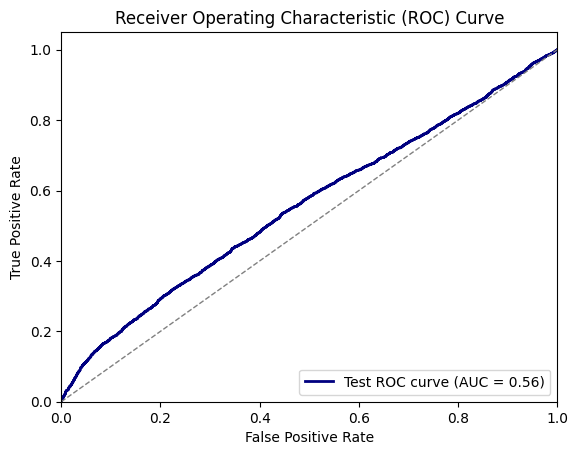

In [49]:
AUC_ROC(final_model, test_X, test_y)

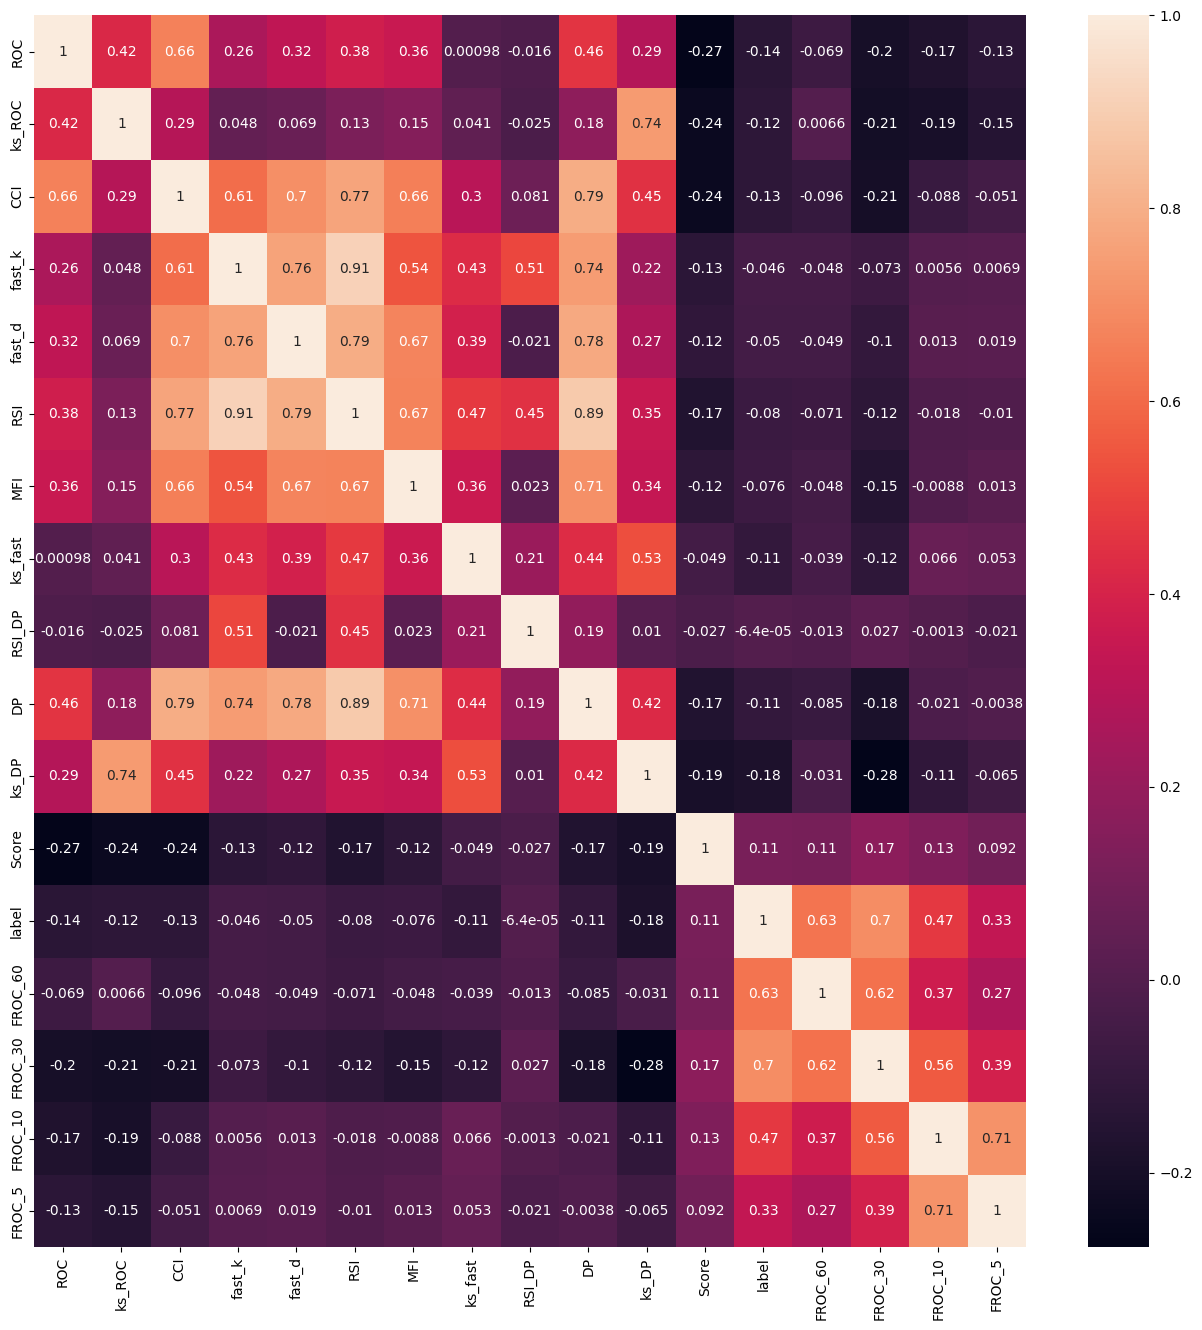

In [50]:
prob = final_model.predict_proba(np.concatenate([train_X, val_X, test_X], axis=0))
data['Score'] = prob[:, 1]
df = data.iloc[len(data)-len(test_y):, :]

fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(df[['ROC', 'ks_ROC', 'CCI', 'fast_k', 'fast_d', 'RSI', 'MFI', 'ks_fast', 'RSI_DP', 'DP', 'ks_DP', 'Score', 'label',
       'FROC_60', 'FROC_30', 'FROC_10', 'FROC_5'
       ]].corr(), ax=ax, annot=True, annot_kws={'size':10}, fmt='.2g')
plt.show()

[FROC_60, Score] pearsonr(0.1073) p-value : 0.0
[FROC_30, Score] pearsonr(0.1729) p-value : 0.0
[FROC_10, Score] pearsonr(0.1326) p-value : 0.0
[FROC_5, Score] pearsonr(0.0922) p-value : 0.0


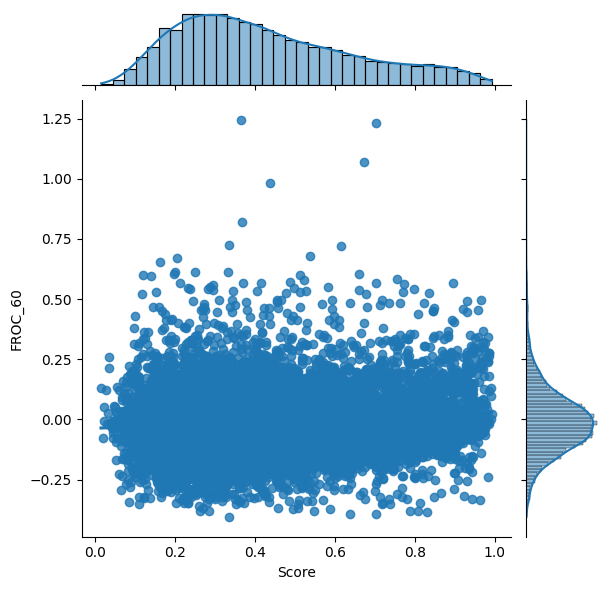

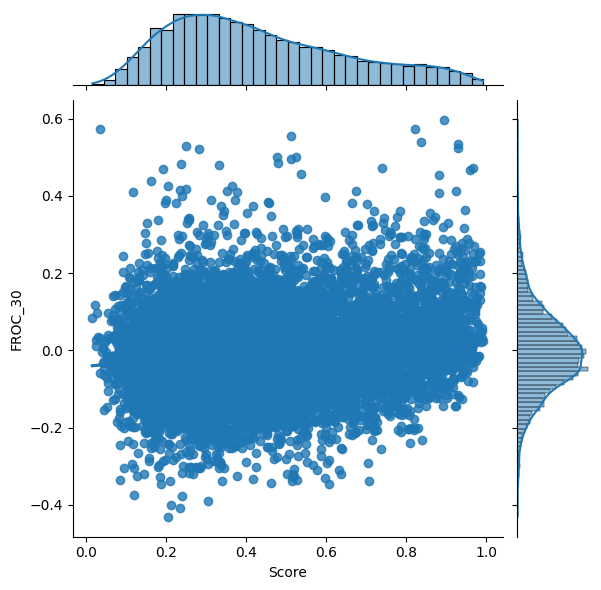

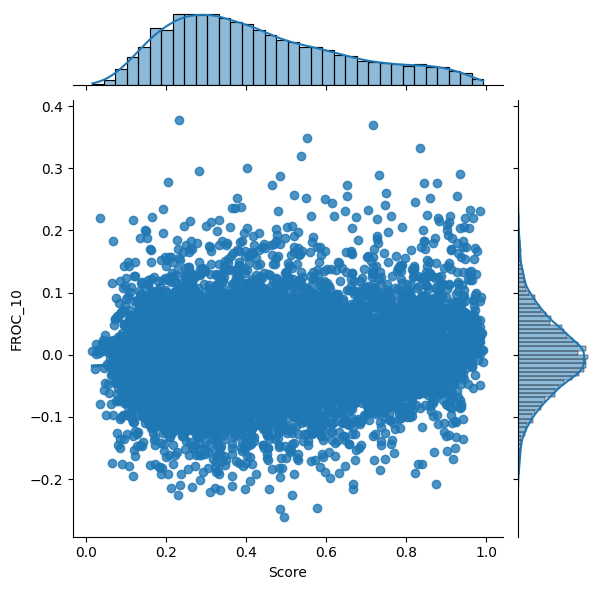

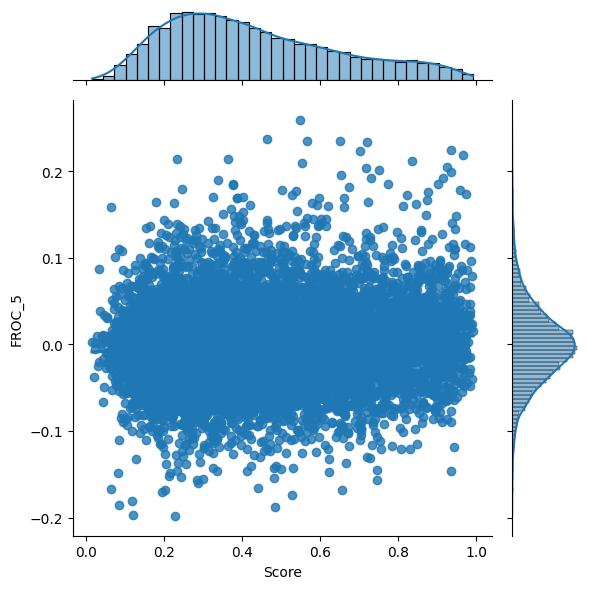

In [51]:
name_list = ['FROC_60', 'FROC_30', 'FROC_10', 'FROC_5']
for name in name_list:
    score_returns_corr, score_returns_pvalue = stats.pearsonr(df['Score'], df[name])
    print(f'[{name}, Score] pearsonr({np.round(score_returns_corr, 4)}) p-value : {np.round(score_returns_pvalue, 6)}')

for i, name in enumerate(name_list):
    sns.jointplot(data=df, x='Score', y=name, kind='reg')
plt.tight_layout()
plt.show()

In [52]:
label_window = (1, 30)
data30, scalers, train_X, val_X, test_X, train_y, val_y, test_y = make_data(stock_dict, window_params, date_range, label_window, scaling_features=scaling_features, model_features=model_features, get_scaler=True)
negative_rate = 1 - np.round(train_y.sum() / len(train_y), 6)

trials30 = Trials()
best = fmin(final_objective, space, algo=anneal.suggest, max_evals=500, trials=trials30, rstate=np.random.default_rng(42))

print('Best Hyperparameters:')
print(space_eval(space, best))

final_model30 = final_objective(space_eval(space, best), eval=True)

100%|██████████| 500/500 [2:07:07<00:00, 15.25s/trial, best loss: -0.5507563504899629]  
Best Hyperparameters:
{'colsample_bytree': 0.9402774715963456, 'gamma': 0.8250662555897774, 'learning_rate': 0.2039973907728778, 'max_depth': 7.0, 'n_estimators': 715.0, 'reg_alpha': 0.885634827958638, 'reg_lambda': 4.821757380800938, 'subsample': 0.7170913141815768}
train + valid 정확도 0.9013890752919071
test          정확도 0.5354728121131321


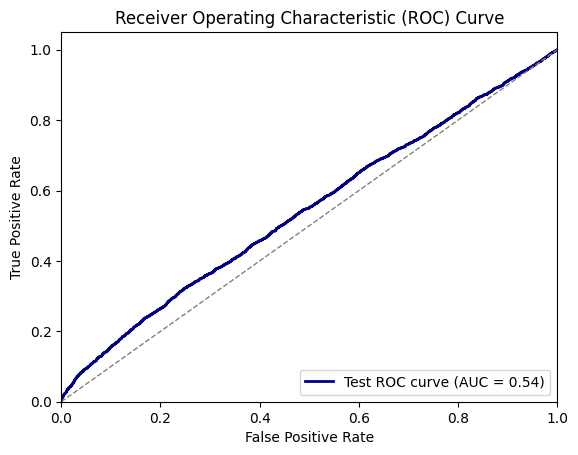

In [53]:
AUC_ROC(final_model30, test_X, test_y)

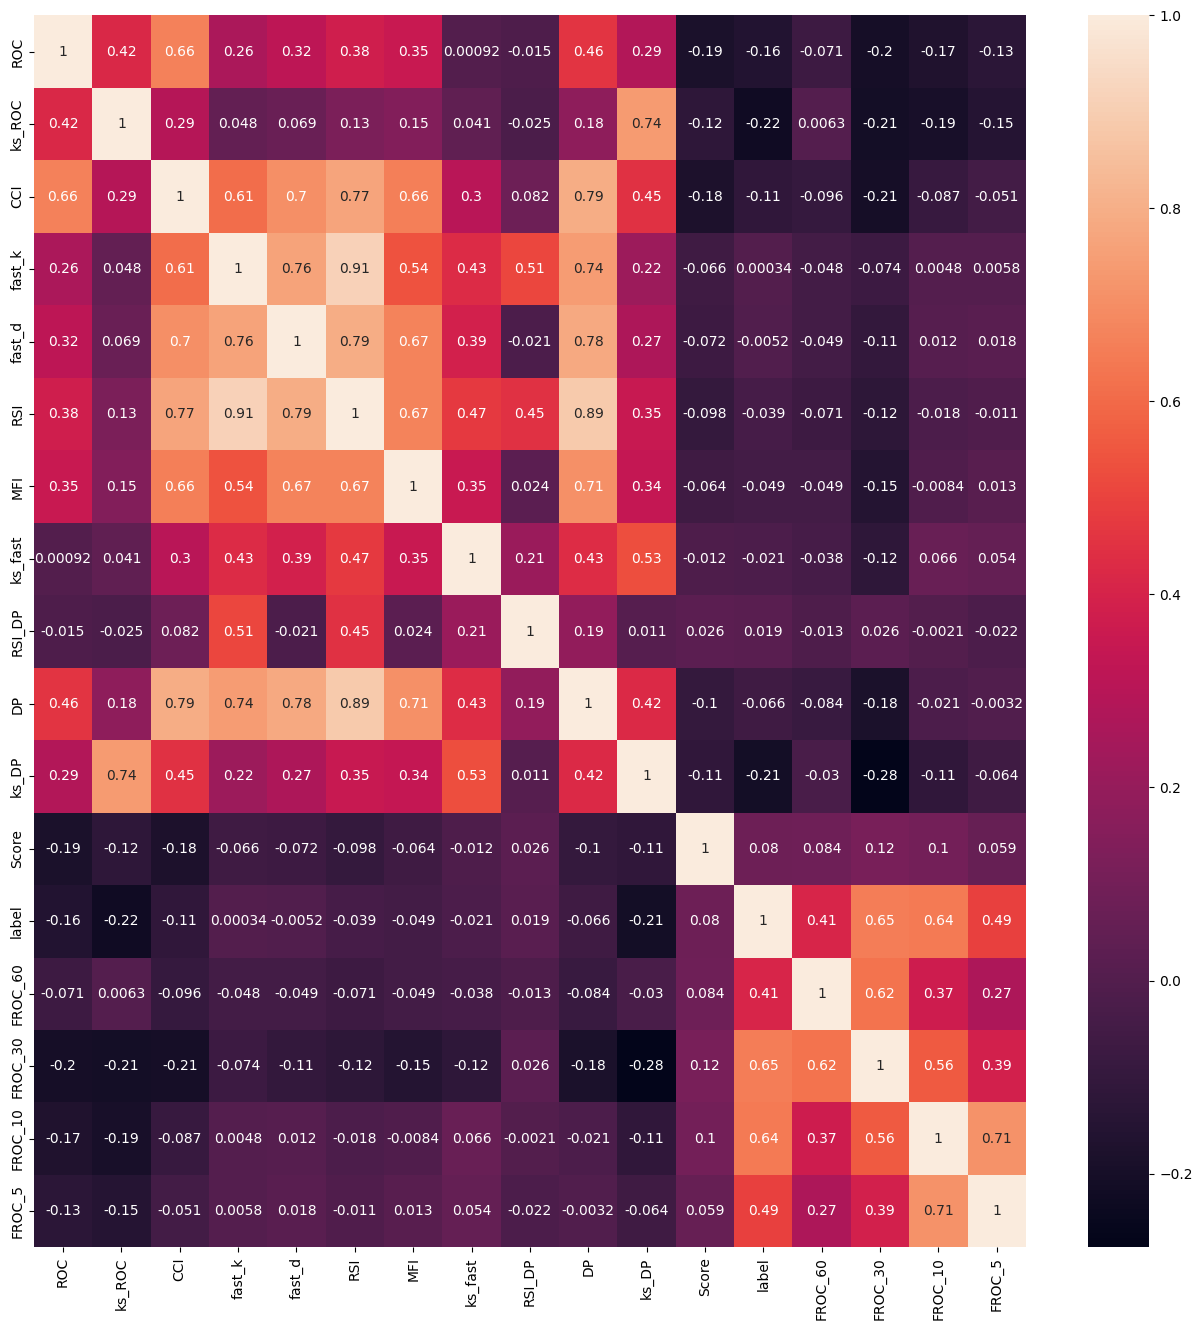

In [54]:
prob = final_model30.predict_proba(np.concatenate([train_X, val_X, test_X], axis=0))
data30['Score'] = prob[:, 1]
df = data30.iloc[len(data30)-len(test_y):, :]

fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(df[['ROC', 'ks_ROC', 'CCI', 'fast_k', 'fast_d', 'RSI', 'MFI', 'ks_fast', 'RSI_DP', 'DP', 'ks_DP', 'Score', 'label',
       'FROC_60', 'FROC_30', 'FROC_10', 'FROC_5'
       ]].corr(), ax=ax, annot=True, annot_kws={'size':10}, fmt='.2g')
plt.show()

[FROC_60, Score] pearsonr(0.0836) p-value : 0.0
[FROC_30, Score] pearsonr(0.1168) p-value : 0.0
[FROC_10, Score] pearsonr(0.1006) p-value : 0.0
[FROC_5, Score] pearsonr(0.0594) p-value : 0.0


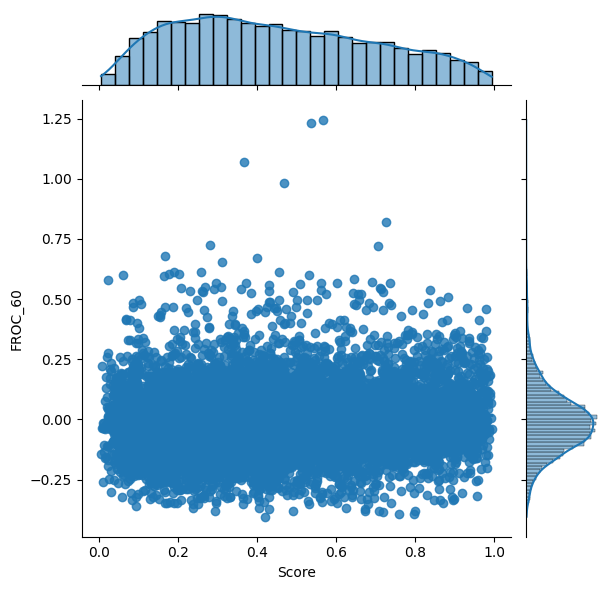

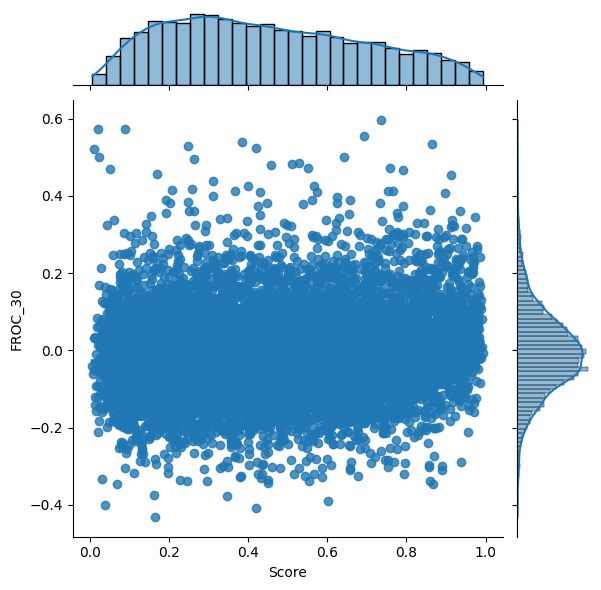

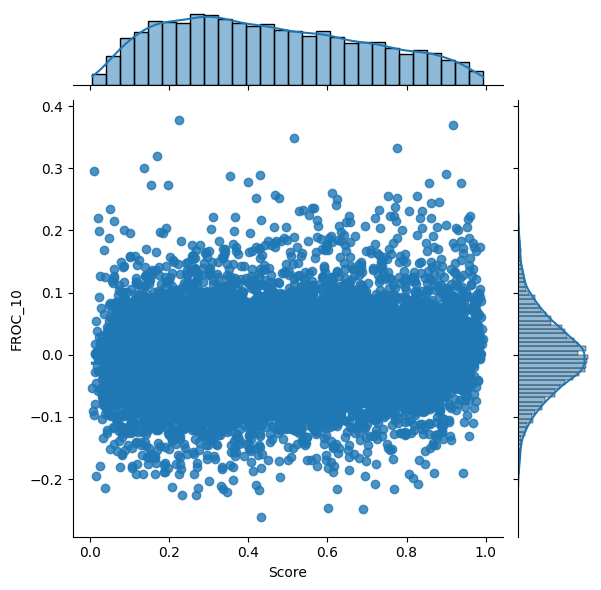

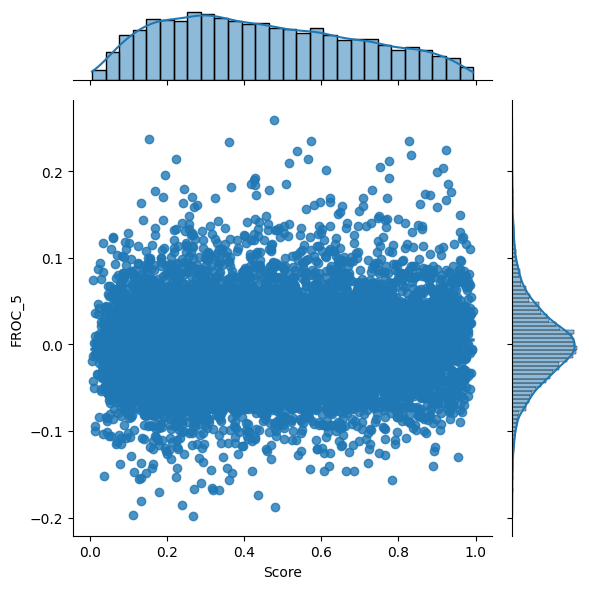

In [55]:
name_list = ['FROC_60', 'FROC_30', 'FROC_10', 'FROC_5']
for name in name_list:
    score_returns_corr, score_returns_pvalue = stats.pearsonr(df['Score'], df[name])
    print(f'[{name}, Score] pearsonr({np.round(score_returns_corr, 4)}) p-value : {np.round(score_returns_pvalue, 6)}')

for i, name in enumerate(name_list):
    sns.jointplot(data=df, x='Score', y=name, kind='reg')
plt.tight_layout()
plt.show()

In [56]:
label_window = (1, 10)
data10, scalers, train_X, val_X, test_X, train_y, val_y, test_y = make_data(stock_dict, window_params, date_range, label_window, scaling_features=scaling_features, model_features=model_features, get_scaler=True)
negative_rate = 1 - np.round(train_y.sum() / len(train_y), 6)

trials10 = Trials()
best = fmin(final_objective, space, algo=anneal.suggest, max_evals=500, trials=trials10, rstate=np.random.default_rng(42))

print('Best Hyperparameters:')
print(space_eval(space, best))

final_model10 = final_objective(space_eval(space, best), eval=True)

100%|██████████| 500/500 [1:16:16<00:00,  9.15s/trial, best loss: -0.5088954428693749]
Best Hyperparameters:
{'colsample_bytree': 0.8013118604178134, 'gamma': 0.4523500609750051, 'learning_rate': 0.20666634036719558, 'max_depth': 5.0, 'n_estimators': 626.0, 'reg_alpha': 2.774637968920442, 'reg_lambda': 3.9893179809620616, 'subsample': 0.7348185627764829}
train + valid 정확도 0.7228559924842303
test          정확도 0.5451861727454528


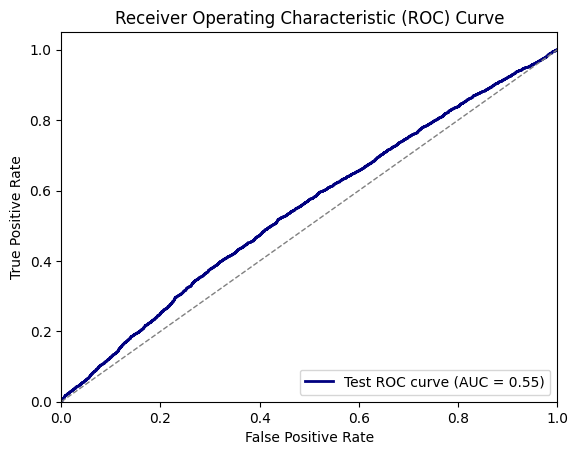

In [57]:
AUC_ROC(final_model10, test_X, test_y)

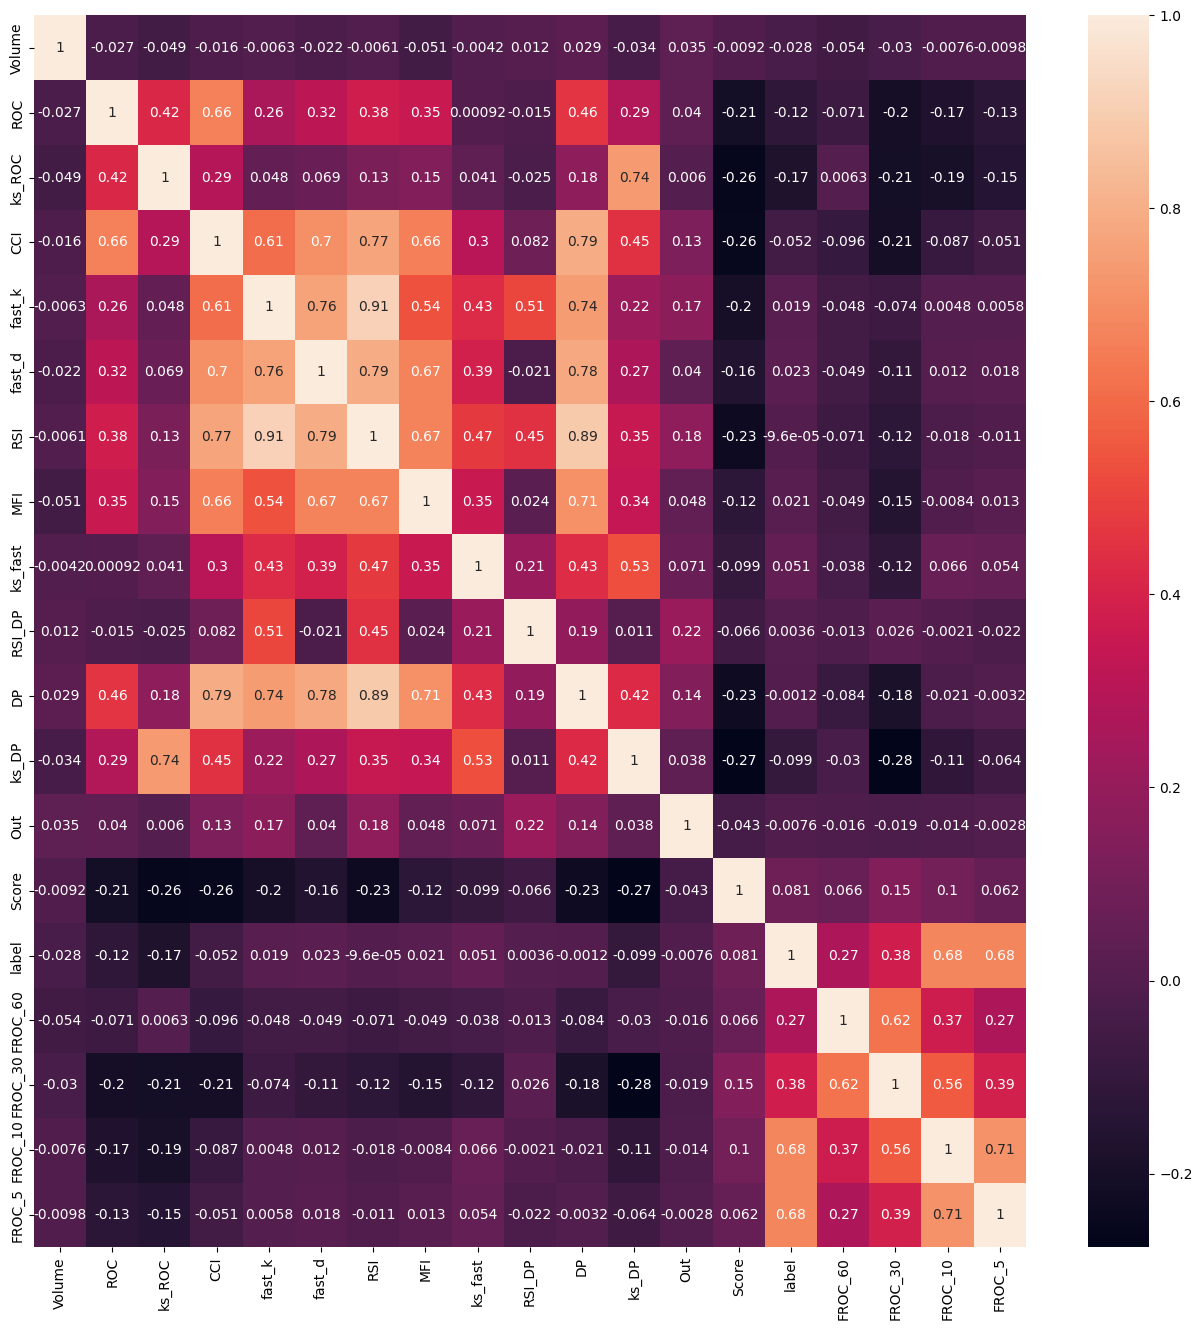

In [58]:
prob = final_model10.predict_proba(np.concatenate([train_X, val_X, test_X], axis=0))
data10['Score'] = prob[:, 1]
df = data10.iloc[len(data10)-len(test_y):, :]

fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(df[['Volume', 'ROC', 'ks_ROC', 'CCI', 'fast_k', 'fast_d', 'RSI', 'MFI', 'ks_fast', 'RSI_DP', 'DP', 'ks_DP', 'Out', 'Score', 'label',
       'FROC_60', 'FROC_30', 'FROC_10', 'FROC_5'
       ]].corr(), ax=ax, annot=True, annot_kws={'size':10}, fmt='.2g')
plt.show()

[FROC_60, Score] pearsonr(0.0657) p-value : 0.0
[FROC_30, Score] pearsonr(0.1467) p-value : 0.0
[FROC_10, Score] pearsonr(0.1021) p-value : 0.0
[FROC_5, Score] pearsonr(0.0618) p-value : 0.0


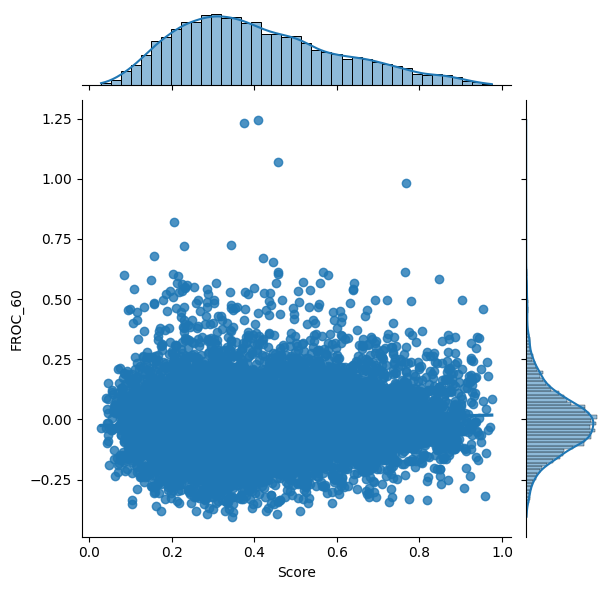

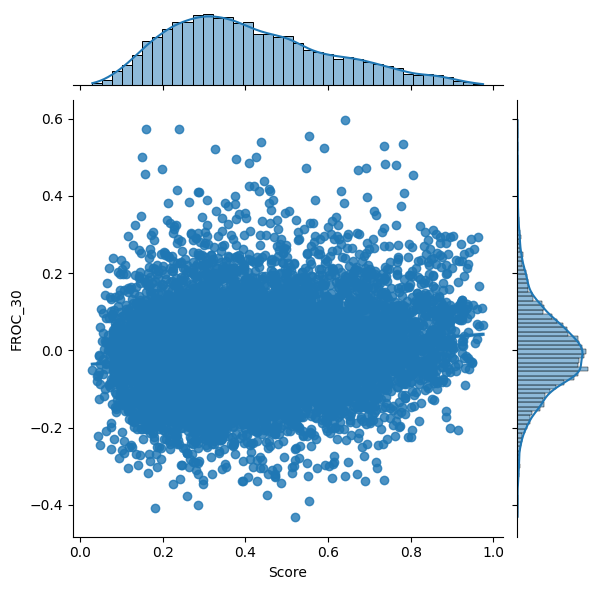

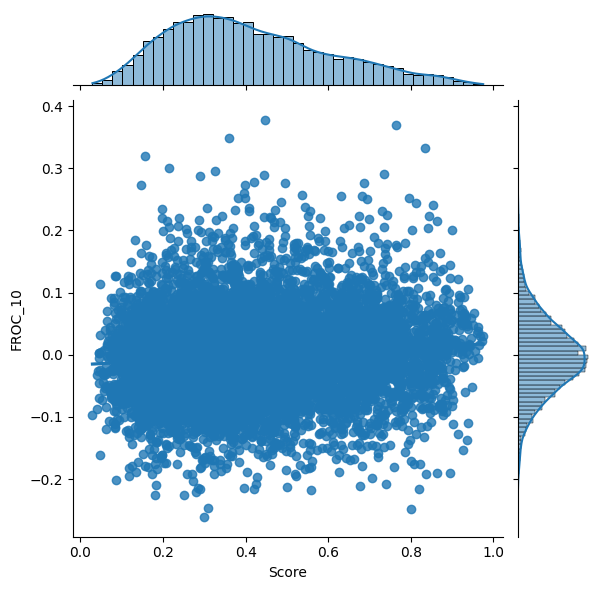

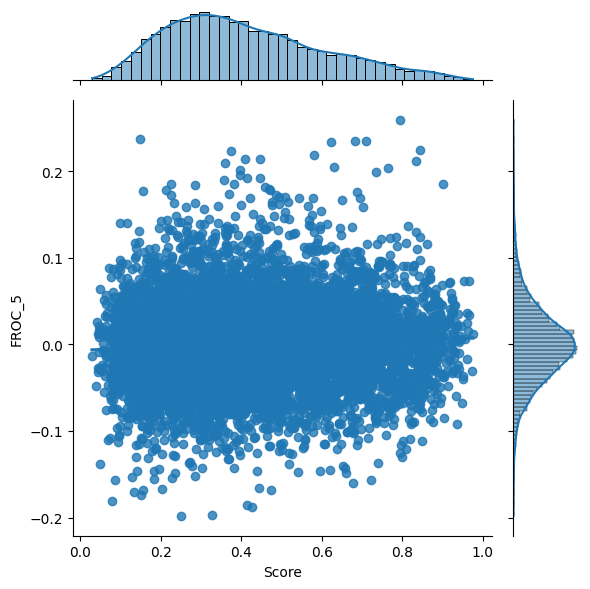

In [59]:
name_list = ['FROC_60', 'FROC_30', 'FROC_10', 'FROC_5']
for name in name_list:
    score_returns_corr, score_returns_pvalue = stats.pearsonr(df['Score'], df[name])
    print(f'[{name}, Score] pearsonr({np.round(score_returns_corr, 4)}) p-value : {np.round(score_returns_pvalue, 6)}')

for i, name in enumerate(name_list):
    sns.jointplot(data=df, x='Score', y=name, kind='reg')
plt.tight_layout()
plt.show()

In [33]:
label_window = (1, 30)
data, scalers, train_X, val_X, test_X, train_y, val_y, test_y = make_data(stock_dict, window_params, date_range, label_window, scaling_features=scaling_features, test_features=True, model_features=model_features, get_scaler=True)
negative_rate = 1 - np.round(train_y.sum() / len(train_y), 6)

LG에너지솔루션 ROC 0.15983665291810661
LG에너지솔루션 ks_ROC 0.3061711823433054
LG에너지솔루션 CCI 0.06778528624983454
LG에너지솔루션 MFI 0.05715101492827541
LG에너지솔루션 ks_DP 0.3403927071804929
하이브 ks_ROC 0.081465232362259
카카오뱅크 ROC 0.06804948210549852
카카오뱅크 ks_ROC 0.12767900135533733
카카오뱅크 CCI 0.061389202292640006
카카오뱅크 ks_DP 0.10520344918424168
HD현대중공업 ROC 0.1205810142387157
HD현대중공업 ks_ROC 0.17141697794163852
HD현대중공업 ks_DP 0.15093067709269792
크래프톤 ROC 0.07717088544073394
크래프톤 ks_ROC 0.13546911036310333
크래프톤 ks_DP 0.10976651992497144


In [34]:
label_window = (1, 10)
data, scalers, train_X, val_X, test_X, train_y, val_y, test_y = make_data(stock_dict, window_params, date_range, label_window, scaling_features=scaling_features, test_features=True, model_features=model_features, get_scaler=True)
negative_rate = 1 - np.round(train_y.sum() / len(train_y), 6)

LG에너지솔루션 ROC 0.15983665291810661
LG에너지솔루션 ks_ROC 0.3061711823433054
LG에너지솔루션 CCI 0.06778528624983454
LG에너지솔루션 MFI 0.05715101492827541
LG에너지솔루션 ks_DP 0.3403927071804929
하이브 ks_ROC 0.081465232362259
카카오뱅크 ROC 0.06804948210549852
카카오뱅크 ks_ROC 0.12767900135533733
카카오뱅크 CCI 0.061389202292640006
카카오뱅크 ks_DP 0.10520344918424168
HD현대중공업 ROC 0.1205810142387157
HD현대중공업 ks_ROC 0.17141697794163852
HD현대중공업 ks_DP 0.15093067709269792
크래프톤 ROC 0.07717088544073394
크래프톤 ks_ROC 0.13546911036310333
크래프톤 ks_DP 0.10976651992497144


In [ ]:
def show_imp(xgb_model, feature_names):
    fig, ax = plt.subplots(figsize=(10, 6))
    importance = xgb_model.feature_importances_
    sorted_idx = np.argsort(importance)

    ax.barh(range(len(feature_names)), importance[sorted_idx])
    ax.set_yticks(range(len(feature_names)))
    ax.set_yticklabels(np.array(feature_names)[sorted_idx])

    plt.show()

# 피처 이름 리스트
feature_names = ['ROC', 'ks_ROC', 'CCI', 'fast_k', 'fast_d', 'RSI', 'MFI', 'ks_fast', 'RSI_DP', 'DP', 'ks_DP']

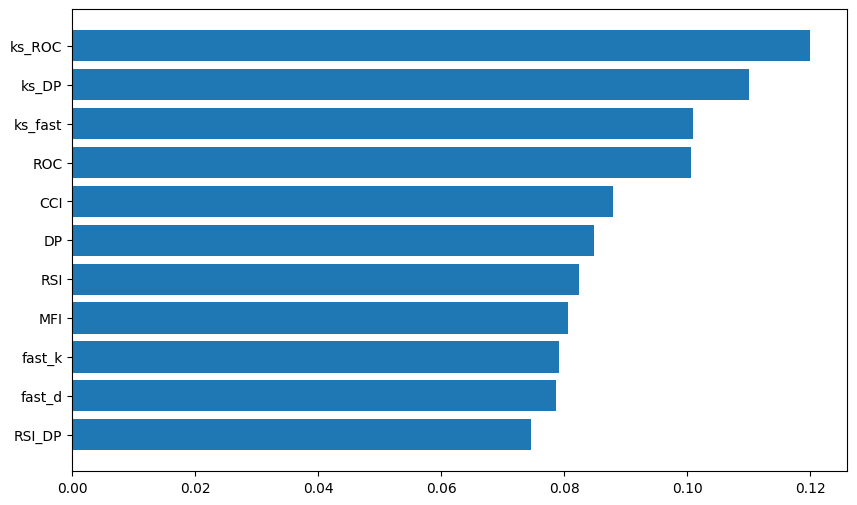

In [62]:
show_imp(final_model, feature_names)

### label window별 feature window-acc 매칭하는 그래프 그리기

In [48]:
xgb_space = {
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
        'max_depth': hp.quniform('max_depth', 3, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 50, 1000, 1),
        'gamma': hp.uniform('gamma', 0, 10),
        'reg_lambda': hp.uniform('reg_lambda', 0, 10),
        'reg_alpha': hp.uniform('reg_alpha', 0, 10),
        'subsample': hp.uniform('subsample', 0, 1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0, 1),
        'MA' : hp.quniform('MA', 1, 24, 1),
        'CCI' : hp.quniform('CCI', 10, 90, 5),
        'fast_k' : hp.quniform('fast_k', 3, 30, 1),
        'fast_d' : hp.quniform('fast_d', 3, 14, 1),
        'ROC' : hp.quniform('ROC', 3, 60, 3),
        'ks_ROC' : hp.quniform('ks_ROC', 3, 60, 3),
        'RSI' : hp.quniform('RSI', 2, 13, 2),
        'MFI' : hp.quniform('MFI', 4, 15, 2),
        'RSI_DP' : hp.quniform('RSI_DP', 2, 9, 1),
        'DP' : hp.quniform('DP', 2, 30, 2),
}

In [49]:
stocks = fdr.StockListing('KOSPI')
stock_name = stocks[['Name', 'Code']]
stock_dict = dict(stock_name.values[:35])
date_range = ['2013-01-01', '2023-05-31']
scaling_features = {'rbc' : ['Volume', 'Change', 'ROC', 'ks_ROC', 'RSI_DP', 'DP', 'ks_DP'],
                    'mmc' : ['Open', 'High', 'Low', 'Close', 'MA_5', 'STD', 'Upper', 'Lower', 'OBV',
                              'MA', 'CCI', 'fast_k', 'fast_d', 'RSI', 'MFI', 'ks_fast']}
model_features = ['ROC', 'ks_ROC', 'CCI', 'fast_k', 'fast_d', 'RSI', 'MFI', 'ks_fast', 'RSI_DP', 'DP', 'ks_DP', 'Out']

label_window = (5, 60)

trials_60 = Trials()
best_60 = fmin(objective, xgb_space, algo=rand.suggest, max_evals=200, trials=trials_60, rstate=np.random.default_rng(42))

print('Best Hyperparameters:')
print(space_eval(xgb_space, best_60))

result_60 = objective(space_eval(xgb_space, best_60), eval=True)

100%|██████████| 200/200 [2:26:57<00:00, 44.09s/trial, best loss: -0.5272473218444341]  
Best Hyperparameters:
{'CCI': 30.0, 'DP': 14.0, 'MA': 24.0, 'MFI': 6.0, 'ROC': 54.0, 'RSI': 4.0, 'RSI_DP': 2.0, 'colsample_bytree': 0.679668045212622, 'fast_d': 10.0, 'fast_k': 17.0, 'gamma': 0.8703375004079883, 'ks_ROC': 18.0, 'learning_rate': 0.21258179337165925, 'max_depth': 8.0, 'n_estimators': 719.0, 'reg_alpha': 4.349979536508063, 'reg_lambda': 4.805571687112412, 'subsample': 0.32503239273547446}
train + valid 정확도 0.8220517201721815
test          정확도 0.5531617235590375


In [50]:
label_window = (5, 30)

trials_30 = Trials()
best_30 = fmin(objective, xgb_space, algo=rand.suggest, max_evals=200, trials=trials_30, rstate=np.random.default_rng(42))

print('Best Hyperparameters:')
print(space_eval(xgb_space, best_30))

result_30 = objective(space_eval(xgb_space, best_30), eval=True)

100%|██████████| 200/200 [2:24:24<00:00, 43.32s/trial, best loss: -0.5565576850807967]  
Best Hyperparameters:
{'CCI': 90.0, 'DP': 26.0, 'MA': 13.0, 'MFI': 6.0, 'ROC': 39.0, 'RSI': 6.0, 'RSI_DP': 7.0, 'colsample_bytree': 0.6817937565367324, 'fast_d': 6.0, 'fast_k': 13.0, 'gamma': 4.893066260569254, 'ks_ROC': 42.0, 'learning_rate': 0.04018194418119183, 'max_depth': 10.0, 'n_estimators': 757.0, 'reg_alpha': 1.0363257401242698, 'reg_lambda': 1.7484062581199022, 'subsample': 0.690882643468507}
train + valid 정확도 0.6810334820318071
test          정확도 0.5919751342187058


In [51]:
label_window = (5, 5)

trials_5 = Trials()
best_5 = fmin(objective, xgb_space, algo=rand.suggest, max_evals=200, trials=trials_5, rstate=np.random.default_rng(42))

print('Best Hyperparameters:')
print(space_eval(xgb_space, best_5))

result_5 = objective(space_eval(xgb_space, best_5), eval=True)

100%|██████████| 200/200 [2:19:45<00:00, 41.93s/trial, best loss: -0.65705866101851]    
Best Hyperparameters:
{'CCI': 70.0, 'DP': 4.0, 'MA': 18.0, 'MFI': 8.0, 'ROC': 9.0, 'RSI': 8.0, 'RSI_DP': 9.0, 'colsample_bytree': 0.18026118992252438, 'fast_d': 9.0, 'fast_k': 22.0, 'gamma': 6.945461357255116, 'ks_ROC': 45.0, 'learning_rate': 0.29294645078742215, 'max_depth': 8.0, 'n_estimators': 648.0, 'reg_alpha': 9.908170627905605, 'reg_lambda': 0.9020039290915138, 'subsample': 0.9596470748675293}
train + valid 정확도 0.6765952609098144
test          정확도 0.6700507614213198


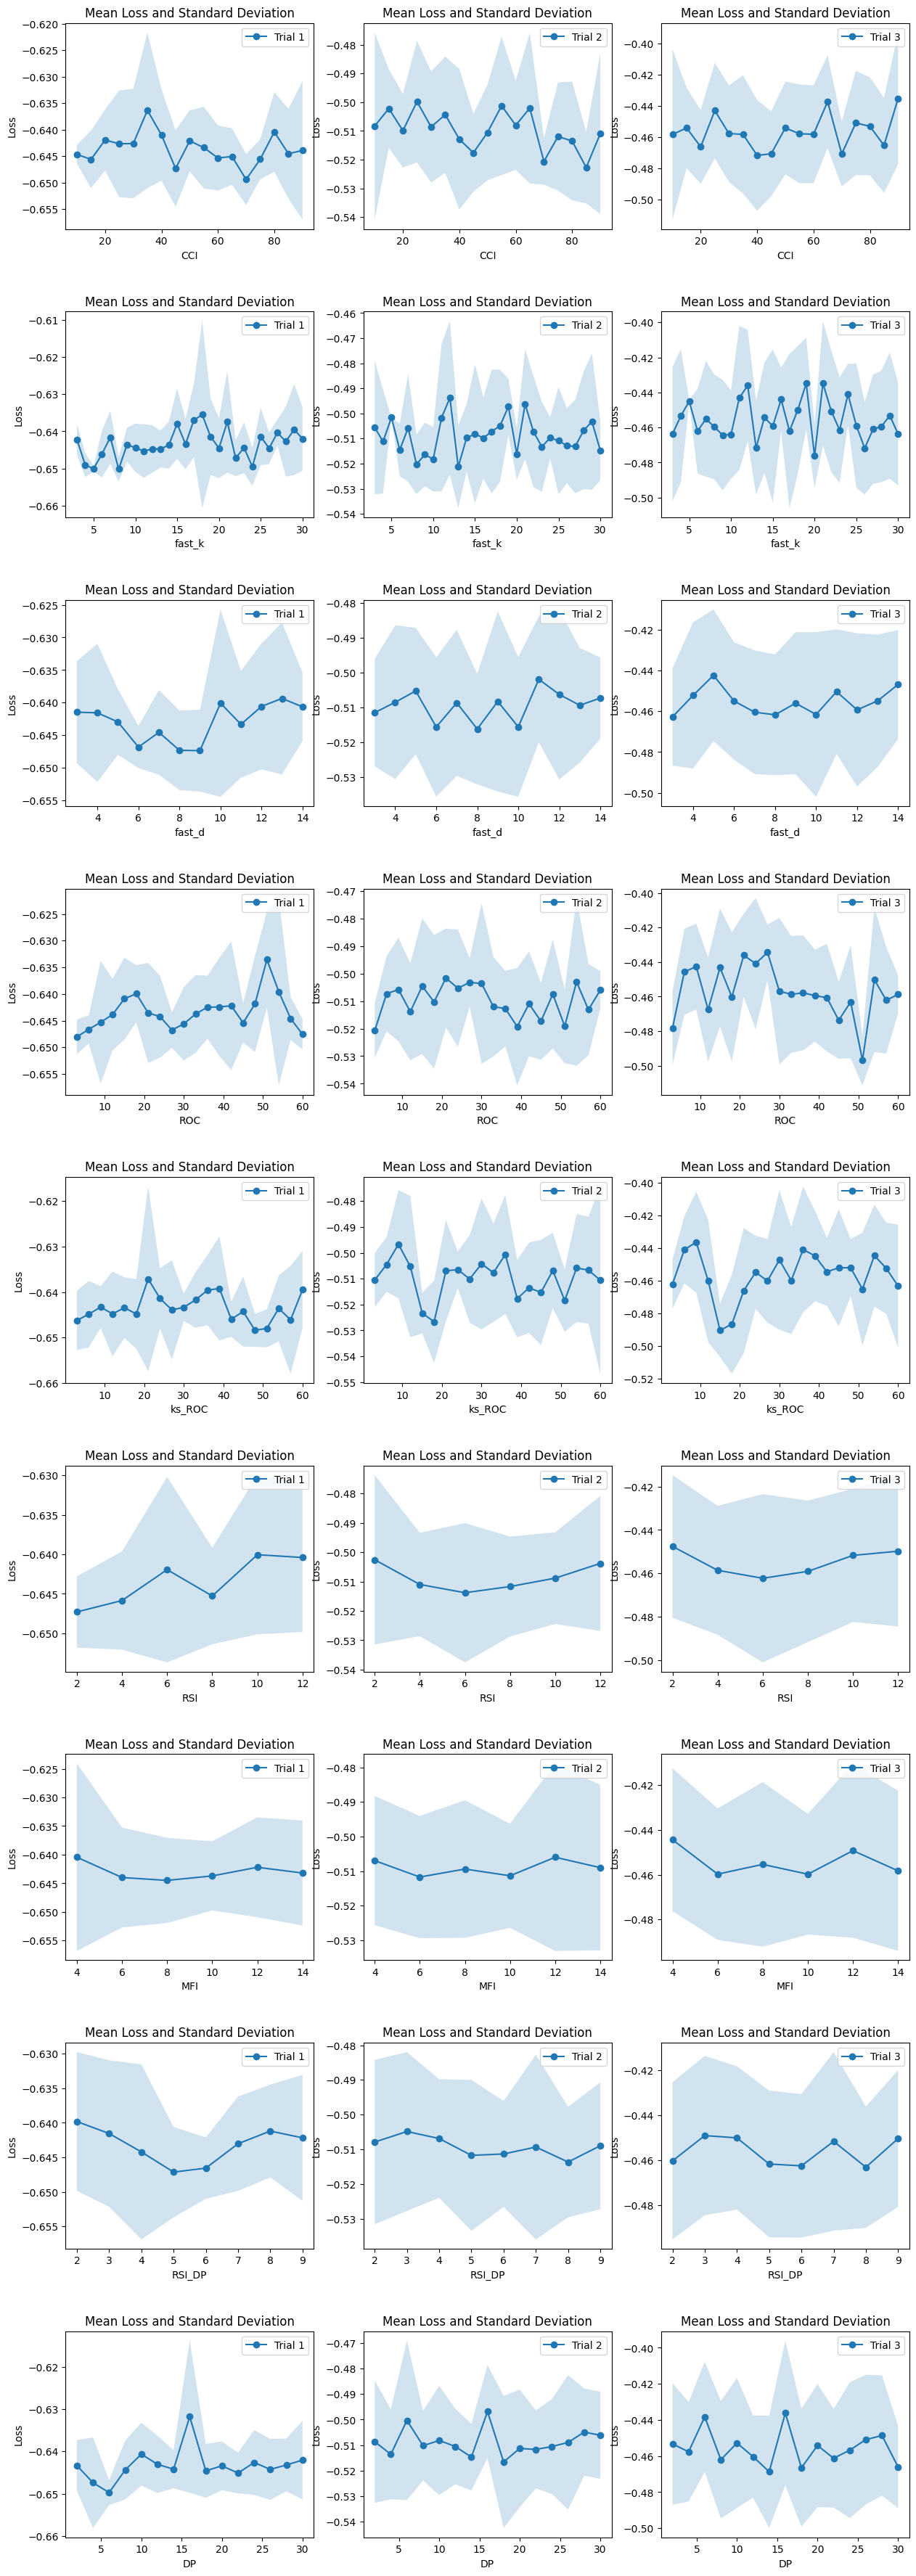

In [52]:
num_params_per_row = 3
num_rows = len(list(xgb_space.keys())[9:])

fig, axes = plt.subplots(num_rows, num_params_per_row, figsize=(15, 5*num_rows))
fig.subplots_adjust(hspace=0.4)

for j, t in enumerate([trials_5, trials_30, trials_60]):
    parameters = [trial['misc']['vals'] for trial in t.trials]
    losses = np.array(t.losses())
    for i in range(num_rows):
        parameter = list(xgb_space.keys())[9:][i]
        parameter_values = [int(params[parameter][0]) for params in parameters]
        unique_values = np.sort(np.unique(parameter_values))
        mean_losses = [np.mean(losses[parameter_values == ma]) for ma in unique_values]
        std_losses = [np.std(losses[parameter_values == ma]) for ma in unique_values]
            
        axes[i, j].plot(unique_values, mean_losses, marker='o', label=f'Trial {j+1}')
        axes[i, j].fill_between(unique_values, np.array(mean_losses) - np.array(std_losses),
                                    np.array(mean_losses) + np.array(std_losses), alpha=0.2)
        
        axes[i, j].set_xlabel(parameter)
        axes[i, j].set_ylabel('Loss')
        axes[i, j].set_title('Mean Loss and Standard Deviation')
        axes[i, j].legend()